In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import *
pd.set_option('max_rows',500)

pd.set_option('display.max_colwidth', -1)

In [2]:
# tickers_in_currents = !ls currents
# tickers_in_currents = [t.replace('.pkl','') for t in tickers_in_currents]
# con = sa.create_engine('sqlite:///edgar_htm_idx.db').connect()
# ticker_df = pd.read_sql('select date, tc.Ticker from idx inner join tickercik tc on tc.CIK=idx.cik where tc.Ticker in {} and type in ("10-K","10-Q")'.format(tuple(tickers_in_currents)), con)

# ticker_df.date = pd.to_datetime(ticker_df.date)
# ticker_df.set_index('date', inplace=True)

In [333]:
# df = pd.read_pickle('sp500_all.pkl')
ticker = 'AAPL'

df = pd.read_pickle('currents/{}.pkl'.format(ticker))
df['ticker'] = ticker
df.startDateTime = pd.to_datetime(df.startDateTime)
df.endDateTime = pd.to_datetime(df.endDateTime, errors='coerce')
df['Days'] = (df.endDateTime - df.startDateTime).dt.days
df.Value = df.Value.astype(float)
df.Account = df.Account.astype(str)
df['endDateTime2'] = df.endDateTime - pd.offsets.Day()

In [326]:
def consolidate_periods(df):
    df_t = df.copy()
    df_t = df_t.drop_duplicates(subset=['Period'])
    df_t.sort_values(['startDateTime','endDateTime2'], inplace=True)
    df_t['to_consolidate'] = df_t.startDateTime.duplicated(keep='first')
    df_t['startDateTime2'] = df_t['startDateTime']
    df_t['Value2'] = df_t['Value']
    df_t.reset_index(drop=True, inplace=True)
    
    def consolidate(row):
        if row.to_consolidate:
            row.Value2 = row.Value - df_t.Value.iloc[row.name-1]
            row.startDateTime2 = df_t.endDateTime.iloc[row.name-1]
        return row
    
    if len(df_t)>1:
        df_t = df_t.apply(consolidate, 1)
        
    df_t = df_t.drop(['startDateTime','endDateTime','Value'],1)
    df_t['Days2'] = (df_t.endDateTime2 - df_t.startDateTime2).dt.days + 1
    df_t['Period2'] = df_t.startDateTime2.dt.strftime('%Y-%m-%d')+df_t.endDateTime2.dt.strftime('%Y-%m-%d')
    
    return df_t

def get_consolidated_df(df):
    df_t = df.query("isStartEndPeriod and Category==False").copy()
    df_t = df_t.groupby(['Account','startDateTime']).apply(consolidate_periods).reset_index(drop=True)
    df_t = df_t.drop_duplicates(subset=['Account','startDateTime2','Period2'])
    return df_t

In [334]:
df_periods = get_consolidated_df(df)

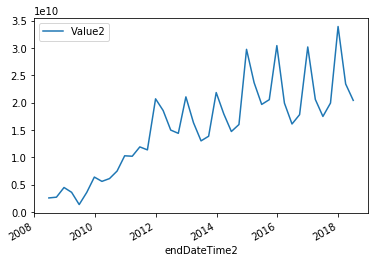

In [343]:
df_periods[(df_periods.Account=='us-gaap:GrossProfit') &
           (df_periods.Days2<100)].sort_values('endDateTime2').plot(x='endDateTime2',y='Value2')

In [330]:
df_periods[(df_periods.Account=='us-gaap:InterestPaid') &
           (df_periods.Days2<100)].sort_values('endDateTime2')

,Account,Category,Period,ContextID,isStartEndPeriod,isInstantPeriod,isForeverPeriod,ticker,Days,endDateTime2,to_consolidate,startDateTime2,Value2,Days2,Period2
1493,us-gaap:InterestPaid,False,2011-01-012011-09-30,D2011Q3YTD,True,False,False,FB,273.0,2011-09-30,True,2011-07-01,6000000.0,92,2011-07-012011-09-30
1494,us-gaap:InterestPaid,False,2011-01-012011-12-31,D2011Q4YTD,True,False,False,FB,365.0,2011-12-31,True,2011-10-01,9000000.0,92,2011-10-012011-12-31
1495,us-gaap:InterestPaid,False,2012-01-012012-03-31,D2012Q1QTD,True,False,False,FB,91.0,2012-03-31,False,2012-01-01,9000000.0,91,2012-01-012012-03-31
1496,us-gaap:InterestPaid,False,2012-01-012012-06-30,eol_PE673740--1210-Q0005_STD_182_20120630_0,True,False,False,FB,182.0,2012-06-30,True,2012-04-01,10000000.0,91,2012-04-012012-06-30
1497,us-gaap:InterestPaid,False,2012-01-012012-09-30,D2012Q3YTD,True,False,False,FB,274.0,2012-09-30,True,2012-07-01,11000000.0,92,2012-07-012012-09-30
1498,us-gaap:InterestPaid,False,2012-01-012012-12-31,D2012Q4YTD,True,False,False,FB,366.0,2012-12-31,True,2012-10-01,8000000.0,92,2012-10-012012-12-31
1499,us-gaap:InterestPaid,False,2013-01-012013-03-31,D2013Q1QTD,True,False,False,FB,90.0,2013-03-31,False,2013-01-01,12000000.0,90,2013-01-012013-03-31
1500,us-gaap:InterestPaid,False,2013-01-012013-06-30,D2013Q2YTD,True,False,False,FB,181.0,2013-06-30,True,2013-04-01,14000000.0,91,2013-04-012013-06-30
1501,us-gaap:InterestPaid,False,2013-01-012013-09-30,D2013Q3YTD,True,False,False,FB,273.0,2013-09-30,True,2013-07-01,7000000.0,92,2013-07-012013-09-30
1502,us-gaap:InterestPaid,False,2013-01-012013-12-31,FD2013Q4YTD,True,False,False,FB,365.0,2013-12-31,True,2013-10-01,5000000.0,92,2013-10-012013-12-31


In [336]:
df_periods[(df_periods.Days2<100)].Account.value_counts()

us-gaap:IncomeTaxExpenseBenefit                                                                                                                      41
us-gaap:NonoperatingIncomeExpense                                                                                                                    41
us-gaap:WeightedAverageNumberOfSharesOutstandingBasic                                                                                                41
us-gaap:OperatingIncomeLoss                                                                                                                          41
us-gaap:EarningsPerShareDiluted                                                                                                                      41
us-gaap:GrossProfit                                                                                                                                  41
us-gaap:EarningsPerShareBasic                                                           